This note book is for trying out new features and then deploy the definition into the scripts.

In this note book, we do not call objects from model.dataEngine, but deploy methods into model.dataEngine.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import model.performance
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature
from utility.feature import FeatureCM

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:03<00:00, 856.78it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


In [3]:
# Initialise feature obj
feature = Feature(df_datesFrame)

feature.add_usageTime(df_lesson1, df_incomp1)
feature.add_progressions(df_lesson1)
feature.add_age(df_pupils)
#feature.add_mathAge(df_lesson1, df_incomp1)
feature.add_outcome(df_lesson1)
feature.add_mark(df_lesson1, df_incomp1)
feature.add_hardship(df_lesson1, df_incomp1)

+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.
+ Add feature: mark.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.


## FeatureCM Object

In [4]:
cmonth = 3
ftrCM = FeatureCM(feature, cmonth, df_subspt1, df_pupils, cfg)

ftrCM.add_usageTime()
ftrCM.add_progress()
ftrCM.add_age()
ftrCM.add_outcome()
ftrCM.add_hardship()
ftrCM.add_mark()

#ftrCM.add_mathAge()
    
df = ftrCM.df_whizz_

In customer month 3:
Number of subscribed pupils (Annual)        = 1939 (0)
Number of active pupils                     = 1297
Number of inactive pupils                   = 642
Number of pupils with churn option          = 1939
Number of active pupils with churn option   = 1297
Number of inactive pupils with churn option = 642


In [5]:
df_whizz = pd.DataFrame()
nmonth = df_subspt1.customer_month.max()
#nmonth = 49

warnings.filterwarnings('ignore')
for cmonth in tqdm(range(1, nmonth+1)):
    
    ftrCM = FeatureCM(feature, cmonth, df_subspt1, df_pupils, cfg, verbose=False)
    
    ftrCM.add_usageTime()
    ftrCM.add_progress()
    ftrCM.add_age()
    ftrCM.add_outcome()
    ftrCM.add_hardship()
    ftrCM.add_mark()
    #ftrCM.add_mathAge()
    
    df = ftrCM.df_whizz_
    
    df_whizz = pd.concat([df_whizz, df], axis=0)
warnings.filterwarnings('default')

df_whizz.head()

100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


,num_attempt,num_complete,num_incomplete,rate_incomplete_num,customer_month,churn,last_access,active,calendar_month,holiday,...,help_sd1,help_sd2,usage_sd0,usage_sd1,usage_sd2,sum_help,rate_stackDepth23_num,rate_stackDepth23_usage,mark_complete,mark_incomplete
pupilId,,,,,,,,,,,,,,,,,,,,,
655886,13.0,12.0,1.0,0.076923,1,0,29,1,11,0,...,24.0,0.0,0.0,6486.0,0.0,24.0,0.000000,0.000000,49.629630,0.0
660299,22.0,17.0,5.0,0.227273,1,0,29,1,8,0,...,1.0,0.0,497.0,2428.0,0.0,5.0,0.000000,0.000000,94.892857,0.0
660470,47.0,47.0,0.0,0.000000,1,0,7,1,3,0,...,60.0,0.0,0.0,8901.0,0.0,60.0,0.000000,0.000000,80.318182,NaN
660512,47.0,47.0,0.0,0.000000,1,0,2,1,3,0,...,93.0,0.0,0.0,21348.0,56.0,93.0,0.021277,0.002616,66.543956,NaN
660787,34.0,34.0,0.0,0.000000,1,0,18,1,3,0,...,98.0,0.0,0.0,6584.0,113.0,98.0,0.029412,0.016873,77.499026,NaN


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


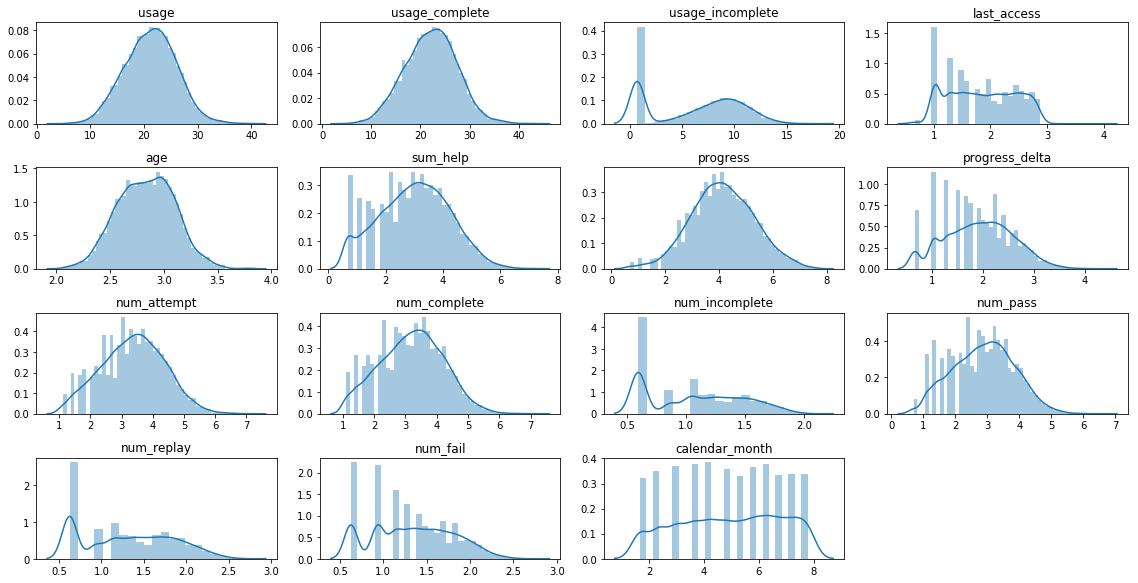

In [6]:
df_whizz1 = df_whizz.set_index(['customer_month'], append=True, inplace=False)
df_whizz1 = df_whizz.reset_index()
df_whizz1.set_index(['customer_month', 'pupilId'], inplace=True)

mask_inactive = df_whizz1.active==0
mask_noassess = (df_whizz1.assess==0) & (df_whizz1.active==1)
mask_fine = ~mask_inactive & ~mask_noassess

df_whizz1 = df_whizz1[mask_fine]
# One hot encoding on calendar month
#df_cal_month = pd.get_dummies(df_whizz1['calendar_month'])
#df_whizz1 = pd.concat([df_cal_month, df_whizz1], axis=1)

#mask = (~df_whizz1['ave_stackDepth'].isna()) & \
#       (~df_whizz1['rate_fail'].isna()) & \
#       (~df_whizz1['rate_pass'].isna())
#df_whizz1 = df_whizz1[mask]

from scipy.stats import boxcox
import seaborn as sns

ftr_list = ['usage', 'usage_complete', 'usage_incomplete',
            'last_access', 
            'age',
            'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'num_complete', 'num_incomplete', 
            'num_pass', 'num_replay', 'num_fail',
            'calendar_month'
           ]
ftr_list_nontransform = ['age', 'math_age', 'age_diff']
#ftr_list = ['usage', 'progress']
ftr_list_nontransform = []

X = []
Xt = []

n_col = 4
n_ftr = len(ftr_list)
n_row = n_ftr // n_col
n_row +=  n_ftr % n_col
pos = range(1, n_ftr+1)

fig = plt.figure(figsize=(4*n_col,2*n_row))
for i, ftr in enumerate(ftr_list):
    ax = fig.add_subplot(n_row, n_col, pos[i])
    x = df_whizz1[ftr].values+2
    
    if ftr in ftr_list_nontransform:
        sns.distplot(x)
        ax.set_title(ftr)
    else:
        if ftr == 'age_diff':
            x += 10
        xt,_ = boxcox(x)
        Xt.append(xt)
        sns.distplot(xt)
        ax.set_title(ftr)
        
    X.append(x)
plt.tight_layout()
    
X = np.array(X).transpose()
Xt = np.array(Xt).transpose()
y = df_whizz1.churn.values

C:\Users\User\Anaconda3\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


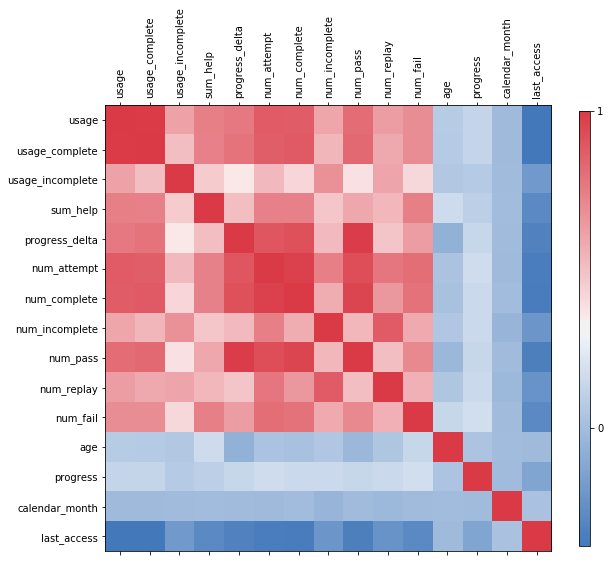

In [7]:
utility.plotlib.feature_correlation(df_whizz1[ftr_list])

## PCA on features

## Pre-process data

In [9]:
# apply PCA to the dataset for visualisation
# i.e. reduce the number of dimensions to 2

# scale data to have unit variance
import mglearn

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # only keep the first two principal components
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# plot the first vs. second pc, colored by class
#plt.figure(figsize=(8,8))
#mglearn.discrete_scatter(X_pca[:,0], X_pca[:,1], y)
#plt.gca().set_aspect('equal')
#plt.xlabel('First principal component')
#plt.ylabel('Second principal component')

# visualise the 'importance' attribute of original features to each principal component

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(ftr_list)), ftr_list, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

ModuleNotFoundError: No module named 'Image'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=10).fit(X_train_scaled, y_train)
print('Training set score: ', logreg.score(X_train_scaled, y_train))
print('Test set score: ', logreg.score(X_test_scaled, y_test))

Training set score:  0.896042528056704
Test set score:  0.9011339475549256


In [9]:
logreg.predict(X_test_scaled).sum()

0

## Decision Tree

In-sample accuracy:  0.9024217365623154
Out-sample accuracy:  0.9004252303330971
Feature importance:  [0.02 0.04 0.01 0.   0.65 0.11 0.05 0.   0.   0.05 0.   0.01 0.   0.03
 0.01 0.02 0.   0.   0.   0.   0.  ]


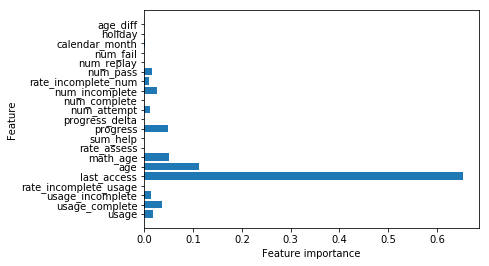

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=2) # the random_state here is used for tie-breaking internally
tree.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', tree.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', tree.score(X_test_scaled, y_test))

print("Feature importance: ", tree.feature_importances_)

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ftr_list)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
plot_feature_importances(tree)

Normalised confusion matrix


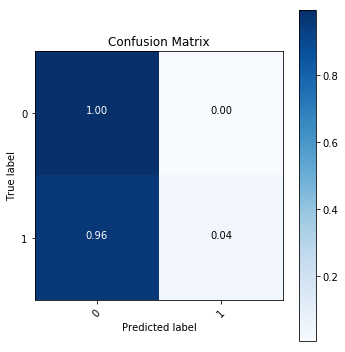

In [13]:
y_pred = tree.predict(X_test_scaled)

cm = model.performance.confusion_matrix(y_test, y_pred, [0,1])

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In-sample accuracy:  0.9050206733608979
Out-sample accuracy:  0.9025513819985825
Normalised confusion matrix


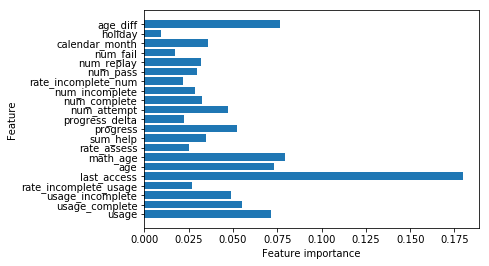

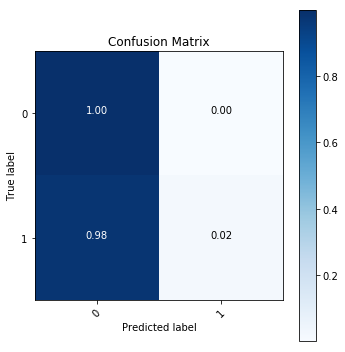

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000, random_state=0, max_depth=10)
forest.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', forest.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', forest.score(X_test_scaled, y_test))

plot_feature_importances(forest)

y_pred = forest.predict(X_test_scaled)

cm = model.performance.confusion_matrix(y_test, y_pred, [0,1])

In-sample accuracy:  0.8853158497242168
Out-sample accuracy:  0.882297845769591


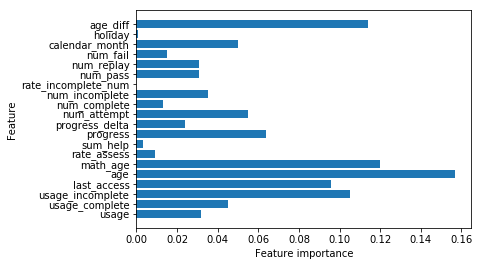

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.1, n_estimators=1000)
gbrt.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', gbrt.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', gbrt.score(X_test_scaled, y_test))

plot_feature_importances(gbrt)

In-sample accuracy:  0.8847955042147986
Out-sample accuracy:  0.882297845769591


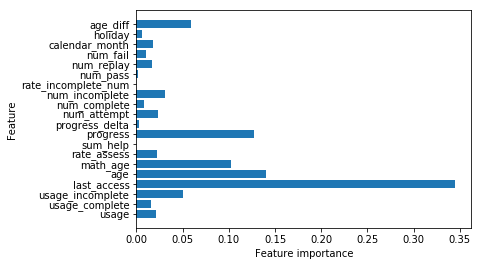

In [12]:
from sklearn.ensemble import AdaBoostClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', bdt.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', bdt.score(X_test_scaled, y_test))

plot_feature_importances(bdt)

In [ ]:
#The usage per customer month is decliing over time
# No activity --> zero in the table, not missing information 
# math age calculation: take into account history info - low priority
# pass and non-pass
# pct of visits they are not in stack depth 1
# time spent on stack depth 2 or 3
# decline in usage time from previous customer month
# 2 features about memories: (1)1/2 month subscribers, (2)length of past subscritions
# Sequency of outcomes/incomplete/reply
# Spending a more time for reply, not for tutors (new lessons), may be afraid of the new lesson difficulties.

## Raw Code - Feature.add_hardship

In [56]:
def bin_stackDepth(df, incomplete_table):
    s0 = df['stackDepth']==0
    s1 = df['stackDepth']==1
    s2 = df['stackDepth']>1
    s0.replace({True:1, False:0}, inplace=True)
    s1.replace({True:1, False:0}, inplace=True)
    s2.replace({True:1, False:0}, inplace=True)
    if not incomplete_table:
        num_sd0 = s0
        num_sd1 = s1
        num_sd2 = s2
    else:
        num_sd0 = s0 * df['count']
        num_sd1 = s1 * df['count']
        num_sd2 = s2 * df['count']
    
    help_sd0 = s0*df['total_help']
    help_sd1 = s1*df['total_help']
    help_sd2 = s2*df['total_help']
    
    col_usage = 'time_taken_incomplete' if incomplete_table else 'time_taken_complete'
    usage_sd0 = s0*df[col_usage]
    usage_sd1 = s1*df[col_usage]
    usage_sd2 = s2*df[col_usage]

    df = df.assign(num_sd0=num_sd0, num_sd1=num_sd1, num_sd2=num_sd2,
                               help_sd0=help_sd0, help_sd1=help_sd1, help_sd2=help_sd2,
                              usage_sd0=usage_sd0, usage_sd1=usage_sd1, usage_sd2=usage_sd2)

#
    return df.groupby(['pupilId','date'])[['num_sd0','num_sd1','num_sd2',
                                                        'help_sd0', 'help_sd1', 'help_sd2',
                                                        'usage_sd0','usage_sd1','usage_sd2']].sum()

df_lesson_stackDepth = bin_stackDepth(df_lesson1, incomplete_table=False)

# Group stackDepth values 2 and 3
temp = df_lesson1.replace({'stackDepth': {3:2}})

# Get from complete lesson table the last valid day of the same stackDepth
df_sd_lastDate = temp.groupby(['pupilId', 'lesson_key', 'stackDepth'])['date'].max()
df_sd_lastDate = df_sd_lastDate.reset_index(level='stackDepth')

# Add a new column date_temp with values 0 for following calculations
df_sd_lastDate = df_sd_lastDate.assign(date_temp=pd.to_timedelta(0))

# Add a new column count with value 1 for following calculations of count of attempts
temp = df_incomp1.assign(count=1)

# Aggregate incomplete lesson records at daily level
df_incomp_dailySum = temp.groupby(['pupilId', 'lesson_key', 'date'])[['time_taken_incomplete', 'total_help', 'count']].sum()
df_incomp_dailySum.reset_index(level='date', inplace=True)

# Add a new column date_temp with values 0 for following calculations
df_incomp_dailySum = df_incomp_dailySum.assign(date_temp=df_incomp_dailySum.date, stackDepth=0)

# Calculate indicator data frame
# In the indicater data frame, the indicater is the column 'date'.
# Because for one attempt in the incomplete lesson table, 'date' is calculated as the date of that attempt minus 
# the last valid date of a stackDepth value of the corresponding attempt in the complete lesson table.
# Hence, if 'date' > 0, then the stackDepth of that incomplete attempt should be 'stackDepth'+1 
df1 = df_sd_lastDate[['date', 'date_temp', 'stackDepth']]
df2 = df_incomp_dailySum[['date', 'date_temp', 'stackDepth']]
df_indicator = df2-df1 

# Keep only those that not NaN. NaN appears when the lesson key is not present in both complete and incomplete lesson tables
df_indicator = df_indicator.dropna()
df_indicator.reset_index(inplace=True)
df_indicator.loc[:, 'stackDepth'] = -df_indicator['stackDepth']

# Keep only records with 'date' <= 0
df_indicator = df_indicator[df_indicator['date']<=pd.to_timedelta(0)]

# For the case where there are multiple 'date' values for the same lesson and date of attempt, take the maximum
# For example, choose -29 if we have -29 and -143. This means to keep the one whose date is closest to last valid date
# of a stackDepth value of the corresponding attempt in the complete lesson table.
df_indicator = df_indicator.loc[df_indicator.groupby(['pupilId','lesson_key','date_temp'])['date'].idxmax()]

df_indicator.drop(columns='date', inplace=True)
df_indicator.rename(columns={'date_temp':'date'}, inplace=True)
df_indicator.set_index(['pupilId', 'lesson_key', 'date'], inplace=True)

# Remove temporary columns which were created for previous calculations
df_incomp_dailySum.drop(columns=['date_temp', 'stackDepth'], inplace=True)

df_incomp_dailySum.set_index(['date'], append=True, inplace=True)

df_incomp_stackDepth = pd.concat([df_incomp_dailySum, df_indicator], axis=1)

# Fill NaN for the stackDepth column by 0
# The stackDepth is NaN only when there is no corresponding attempt in the complete lesson table.
df_incomp_stackDepth.loc[:, 'stackDepth'] = df_incomp_stackDepth['stackDepth'].fillna(0)
df_incomp_stackDepth.reset_index(inplace=True)

df_incomp_stackDepth = bin_stackDepth(df_incomp_stackDepth, incomplete_table=True)

# Combine
df_stackDepth = df_lesson_stackDepth.add(df_incomp_stackDepth, fill_value=0)

## Raw Code - FeatureCM

In [8]:
cmonth = 4

df_features = feature.df_features_
df_features = df_features[df_features['customer_month']>0]

pupils_subspt = df_subspt1[df_subspt1['customer_month']>=cmonth]\
                ['pupilId'].unique()
        
# Identify subscribed pupils who are active and inactive in the customer
# month. 'Active' means the pupils have records kept in lesson history.
df_features1 = df_features[df_features['customer_month']==cmonth]
pupils_active = df_features1.index.get_level_values(level=0).unique()
pupils_inactive = np.setdiff1d(pupils_subspt, pupils_active)

# Identify pupils with churn option
pupils_churnOption = df_subspt1[df_subspt1['customer_month']==cmonth]['pupilId'].unique()
pupils_active_churnOption = np.intersect1d(pupils_active, pupils_churnOption)
pupils_inactive_churnOption = np.intersect1d(pupils_inactive, pupils_churnOption)

print("In customer month {}:".format(cmonth))
print("Number of subscribed pupils                 = {}".\
    format(pupils_subspt.shape[0]))
print("Number of active pupils                     = {}".\
    format(pupils_active.shape[0]))
print("Number of inactive pupils                   = {}".\
    format(pupils_inactive.shape[0]))
print("Number of pupils with churn option          = {}".\
    format(pupils_churnOption.shape[0]))
print("Number of active pupils with churn option   = {}".\
    format(pupils_active_churnOption.shape[0]))
print("Number of inactive pupils with churn option = {}".\
    format(pupils_inactive_churnOption.shape[0]))

In customer month 4:
Number of subscribed pupils                 = 3253
Number of active pupils                     = 2292
Number of inactive pupils                   = 961
Number of pupils with churn option          = 1710
Number of active pupils with churn option   = 1116
Number of inactive pupils with churn option = 594


In [19]:
# Construct the basic data frame
num_complete = df_features1.groupby(level=0)['count_complete'].sum()
num_incomplete = df_features1.groupby(level=0)['count_incomplete'].sum()
df_whizz = pd.DataFrame({'num_complete': num_complete,
                         'num_incomplete': num_incomplete,
                         'num_attempt': num_complete+num_incomplete,
                         'rate_incomplete_num': num_incomplete/\
                         (num_complete+num_incomplete)
                        })

# Append inactive pupils

sr_pupils_inactive = pd.Series(pupils_inactive_churnOption, name='pupilId')
df_whizz_inactive = pd.DataFrame(0, index=sr_pupils_inactive, columns=df_whizz.columns)
df_whizz = df_whizz.append(df_whizz_inactive)

# Identify churner and non-churner
pupils_renew = df_subspt1[df_subspt1['customer_month']>cmonth]['pupilId'].unique()
pupils_churn = np.setdiff1d(pupils_subspt, pupils_renew)

df_whizz = df_whizz.assign(churn=0)
df_whizz.loc[df_whizz.index.isin(pupils_churn), 'churn'] = 1

# Add time since last access
# (1) Add for active pupils
if df_features1.empty:
    time_last_access = pd.Series()
else:
    last_access_date = df_features1.groupby(level=0).apply(
        lambda df: df.index.get_level_values(level=1).max())
    subspt_end_date = df_features1.groupby(level=0)['subscription_end_date'].last()
    time_last_access = (subspt_end_date - last_access_date).dt.days

# (2) Add for inactive pupils
if pupils_inactive_churnOption.size == 0:
    subspt_end_date_inactive = pd.Series()
    time_last_access_inactive = pd.Series()
else:
    df_sd = df_subspt1[
        (df_subspt1['customer_month']==1) & \
        df_subspt1['pupilId'].isin(pupils_inactive_churnOption)][['pupilId', 'subscription_start_date']]
    df_sd.set_index(['pupilId'], inplace=True)
    subspt_start_date_inactive = df_sd['subscription_start_date']

    df_ed = df_subspt1[
        (df_subspt1['customer_month']==cmonth) & \
        df_subspt1['pupilId'].isin(pupils_inactive_churnOption)][['pupilId', 'subscription_end_date']]
    df_ed.set_index(['pupilId'], inplace=True)
    subspt_end_date_inactive = df_ed['subscription_end_date']

    if cmonth == 1:
        time_last_access_inactive = (subspt_end_date_inactive - subspt_start_date_inactive).dt.days
    else:
        def calc(df):
            pupilId = df.name
    
            spt_end_date = subspt_end_date_inactive.loc[pupilId]
            mask = df.index.get_level_values(level=1) < spt_end_date
            last_date = df[mask].index.get_level_values(level=1).max()

            return last_date
    
        mask_inactive = df_features.index.get_level_values(level=0).isin(pupils_inactive_churnOption)
        mask_cm = df_features['customer_month'] < cmonth

        # If the pupil has been active in the past, then find the latest active date in history
        last_access_date_inactive = df_features[mask_inactive & mask_cm].groupby(level=0).apply(calc)

        # If the pupil has neve been active in the past, then assign the subscription start date of the first ever subscription
        last_access_date_inactive.loc[last_access_date_inactive.isna()] = subspt_start_date_inactive
        pupils_activePast = last_access_date_inactive.index.unique().values
        pupils_neverActive = np.setdiff1d(pupils_inactive_churnOption, pupils_activePast)
        last_access_date_neverActive = subspt_start_date_inactive[pupils_neverActive]
        last_access_date_inactive = last_access_date_inactive.append(last_access_date_neverActive)

        time_last_access_inactive = (subspt_end_date_inactive - last_access_date_inactive).dt.days

df_whizz = df_whizz.assign(last_access=time_last_access.append(time_last_access_inactive))

# Add active/inactive label
sr_active = pd.Series(1, index=pupils_active_churnOption)
sr_inactive = pd.Series(0, index=pupils_inactive_churnOption)
df_whizz = df_whizz.assign(active=sr_active.append(sr_inactive))

# Add calendar month label
if not df_features1.empty:
    cal_month = subspt_end_date.dt.month
else:
    cal_month = pd.Series()

cal_month_inactive = subspt_end_date_inactive.dt.month if pupils_inactive_churnOption.size!=0 else pd.Series()

df_whizz = df_whizz.assign(calendar_month=cal_month.append(cal_month_inactive))
        
# Add holiday/term label
df_whizz = df_whizz.assign(holiday=0)
df_whizz.loc[
        df_whizz['calendar_month'].isin(cfg.HOLIDAY_MONTH), 
        'holiday'] = 1

In [ ]:
df_features1[df_features1.index.get_level_values(level=0)==p]
df_subspt1[df_subspt1.pupilId==p]
df_lesson1[df_lesson1.pupilId==p]
df_incomp1[df_incomp1.pupilId==p]

## Raw Code - FeatureCM.add_progress

In [9]:
pupils_churnOption = ftrCM.pupils_churnOption_
pupils_neverActive = ftrCM.pupils_neverActive_
pupils_activePast = ftrCM.pupils_activePast_
last_access_date_inactive = ftrCM.last_access_date_inactive_

df_features = ftrCM.feature.df_features_
df_features1 = df_features[df_features['customer_month']==cmonth]
df_features1 = df_features1[df_features1.index.get_level_values(level=0).isin(pupils_churnOption)]

progress_delta = df_features1.groupby(level=0)['progressions_delta'].sum()
progress = df_features1.groupby(level=0)['progressions'].max()

df_whizz = df.assign(progress=progress, progress_delta=progress_delta)

# Fill progress_delta for inactive pupils
df_whizz.loc[:,'progress_delta'] = df_whizz['progress_delta'].fillna(0.0)

# Fill progress for inactive pupils. We need to search lesson history records in all past customer months
if cmonth == 1:
    df_whizz.loc[:,'progress'] = df_whizz['progress'].fillna(0.0)
else:
    df_whizz.loc[df_whizz.index.isin(pupils_neverActive),'progress'] = 0

    def find_lastProgress(df):
        pupilId = df.name
        last_date = last_access_date_inactive.loc[pupilId]
        progress = df.iloc[:].loc[df.index.get_level_values(level=1)==last_date, 'progressions']
        return progress.values[0]
    
    mask = df_features.index.get_level_values(level=0).isin(pupils_activePast)
    progress_activePast = df_features[mask].groupby(level=0).apply(find_lastProgress)

    df_whizz.loc[df_whizz.index.isin(pupils_activePast),'progress'] = progress_activePast


## Raw Code - FeatureCM.add_hardship

In [6]:
pupils_churnOption = ftrCM.pupils_churnOption_
pupils_inactive_churnOption = ftrCM.pupils_inactive_churnOption_

df_features = ftrCM.feature.df_features_
df_features1 = df_features[df_features['customer_month']==cmonth]
df_features1 = df_features1[df_features1.index.get_level_values(level=0).isin(pupils_churnOption)]

df_hard = df_features1.groupby(level=0)[['num_sd0','num_sd1','num_sd2',
                                         'help_sd0', 'help_sd1', 'help_sd2',
                                         'usage_sd0','usage_sd1','usage_sd2']].sum()

df_hard_inactive = pd.DataFrame(0, index=pupils_inactive_churnOption, columns=df_hard.columns)

df_hard = df_hard.append(df_hard_inactive)

df_hard=df_hard.assign(sum_help=df_hard.help_sd0+df_hard.help_sd1+df_hard.help_sd2,
               rate_stackDepth23_num=df_hard.num_sd2/(df_hard.num_sd0+df_hard.num_sd1+df_hard.num_sd2),
               rate_stackDepth23_usage=df_hard.usage_sd2/(df_hard.usage_sd0+df_hard.usage_sd1+df_hard.usage_sd2))